# Langmuir isotherm predictions improved by modeling relative life with Gaussian process

---

## Introduction

The Langmuir isotherm model assumes constant relative life.[$^{[1]}$](#1) The Toth isotherm model modifies the Langmuir model to provide an empirical improvement. The Toth model was found to fit $q(T, p)$ measurements for zeolite 13X the best.[$^{[2]}$](#2) However, applying a Gaussian regression (GP) to the relative life of the Langmuir model fit even better than the Toth model. The advantage of this method is an improved fit despite the Langmuir isotherm model retaining its simpler analytic form as compared to empirical modifications, such as the Toth isotherm model.

---

## Method

The nomenclature was largely taken from [[1]](#1). In order of appearance in the following equations,

- $\mathbf{GP} \equiv$ Gaussian process model trained using FoKL-GPy
- $\Delta \equiv$ exponent of relative life
- $T \equiv$ temperature
- $p \equiv$ pressure
- $\sigma_1 \equiv$ relative life
- $q \equiv$ amount adsorbed
- $\mu \equiv$ number of gas molecules striking each surface area per time
- $q_{max} \equiv$ maximum possible value of amount adsorbed $q$
- $M \equiv$ molecular weight of adsorbent
- $R \equiv$ universal gas constant
- $q_{cal} \equiv$ calculated predictions of amount adsorbed $q$
- $\sigma_{1, cal} \equiv$ calculated predictions of relative life $\sigma_1$
- $q_s \equiv$ Toth isotherm model parameter theoretically equal to $q_{max}$
- $b \equiv$ Toth isotherm model parameter
- $t \equiv$ Toth isotherm model parameter

The GP model $\mathbf{GP}$ will be trained on $\Delta$ as a function of inverse temperature $T$ and natural logarithim of pressure $p$.

$$\tag{1} \mathbf{GP} = \{\Delta\ |\ T^{-1},\ \ln(p)\}$$

$$\tag{2} \Delta = \ln(\sigma_1)$$

$$\tag{3} \sigma_1 = \frac{q}{\mu(q_{max}-q)}$$

$$\tag{4} \mu = \frac{p}{\sqrt{2 \pi M R T}}$$

$$\tag{5} q_{max} = q_s$$

Then, to make predictions $q_{cal}$ from $\mathbf{GP}$,

$$\tag{6} q_{cal} = \frac{\sigma_{1, cal} q_{max} \mu}{1 + \sigma_{1, cal} \mu}$$

$$\tag{7} \sigma_{1, cal} = \exp(\mathbf{GP})$$

Note from Table 2 and Table 4 of [[2]](#2), respectively, experimental measurements $q(T, p)$ are saved as *data.txt* and Toth model parameters $(q_s, b, t)$ are saved as *toth.txt*. From Equation 2 of [[2]](#2), the Toth model is as follows.

$$\tag{8} q = \frac{q_s p}{(b+p^t)^{1/t}}$$

To obtain $q_{max}$ at any $(T, p)$ pair assuming $q_{max} \propto T$,

$$\tag{9} \mathbf{GP}_{q_{max}} = \{q_{max}\ |\ T\}$$

Since direct measurements of $q_{max}$ were not reported, $q_{max}=q_s$ was assumed for training $\mathbf{GP}_{q_{max}}$; however, experimental or literature values may produce a more accurate model in future work. 

---

## Implementation

Defining limits of where model may be evaluated, increased at the cost of accuracy:

In [2]:
T_min = 200  # Kelvin, temperature
T_max = 400

p_min = 0.01  # kPa, pressure
p_max = 150

Importing modules and defining constants:

In [3]:
# -----------------------------------------------------------------------
# Local version of 'from FoKL import ...':
import os
import sys
dir = os.path.abspath('')  # directory of script
sys.path.append(dir)
sys.path.append(os.path.join(dir, '..', '..', '..'))  # package directory
from src.FoKL import FoKLRoutines
from src.FoKL.fokl_to_pyomo import fokl_to_pyomo
# -----------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from tabulate import tabulate
import pyomo.environ as pyo
from pyomo.environ import *


M = 0.0440095  # molecular weight of CO2, kg/mol
R = 8.31446261815324  # universal gas constant, J/(K*mol)

Loading and parsing data:

In [4]:
# Experimental measurements:

data = np.loadtxt(os.path.join('data', 'data.txt'), skiprows=2)  # experimental measurements q(T, p)

T = data[:, 0]  # K
p_kPa = data[:, 1]  # kPa
p = p_kPa * 1e3  # kPa to Pa
q = data[:, 2]  # mol/kg

T_const = np.where(T[:-1] != T[1:])[0]  # indices where experiment ends (i.e., where next temperature changes)
T_const = np.insert(T_const + 1, [0, len(T_const)], [0, len(T)])  # indices where experiments begin (including "next" experiment enabling 'data[T_const[i]:T_const[i + 1], :]')
n = len(T_const) - 1  # number of experiments
nd = np.array(list(T_const[i + 1] - T_const[i] for i in range(n)))  # number of datapoints in each experiment

# Toth model:

toth = np.loadtxt(os.path.join('data', 'toth.txt'), skiprows=2)  # model parameters (qs, b, t)

qs = np.repeat(toth[:, 1], nd)  # mol/kg, 'np.repeat(x, nd)' for repeating experiments' single values at each datapoint
b = np.repeat(toth[:, 2], nd)  # kPa
t = np.repeat(toth[:, 3], nd)

Defining equations:

In [5]:
def eq2(sigma1):
    """Delta"""
    return np.log(sigma1)

def eq3(q, mu, qmax):
    """sigma1"""
    return q / mu / (qmax - q)

def eq4(p, M, R, T):
    """mu"""
    return p / np.sqrt(2 * np.pi * M * R * T)

def eq6(sigma1, qmax, mu):
    """qcal"""
    return sigma1 * qmax * mu / (1 + sigma1 * mu)

def eq8(qs, b, t, p_kPa):
    """qcal_Toth, where p is in kPa. Equation 2 of [2]."""
    return qs * p_kPa / (b + p_kPa ** t) ** (1 / t)

Calculating training set $\{\Delta\ |\ T^{-1},\ \ln(p)\}$:

In [6]:
mu = eq4(p, M, R, T)
qmax = qs
sigma1 = eq3(q, mu, qmax)
Delta = eq2(sigma1)

inv_T = 1 / T
ln_p = np.log(p)

Training $\mathbf{GP}$:

In [7]:
GP = FoKLRoutines.FoKL(kernel=1, UserWarnings=False)
_ = GP.fit([inv_T, ln_p], Delta, clean=True, minmax=[[1 / T_max, 1 / T_min], [np.log(p_min), np.log(p_max)]])

[1, -384.15314356452643]
[2, -596.4859900152481]
[2, -689.7722949998185]
[3, -712.7786065674467]
[3, -717.4982756892417]
[4, -717.4982756892417]
[4, -714.9093182144513]
[4, -711.9467450701538]


Inpsecting validation plot to confirm accuracy of $\mathbf{GP}$:

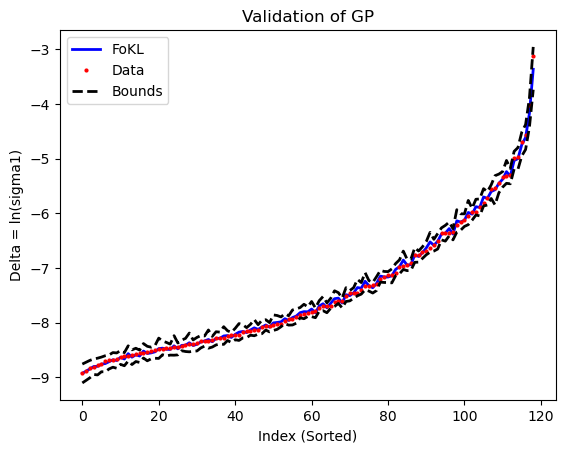

RMSE = 0.002422318180114214


In [8]:
_, _, rmse = GP.coverage3(plot='sorted', ylabel='Delta = ln(sigma1)', title='Validation of GP')
print(f"RMSE = {rmse}")

Plotting $\mathbf{GP}$ at each experimental temperature:

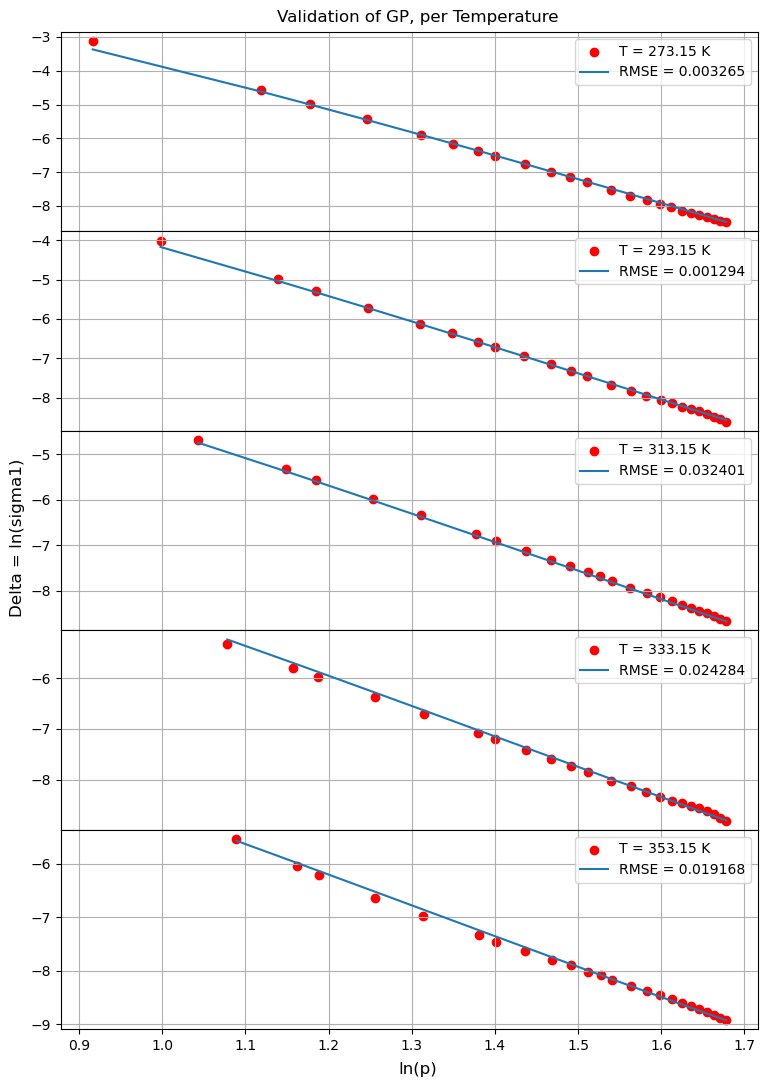

In [33]:
fig, axs = plt.subplots(n, figsize=(8.5, 11), sharex=True)
offset = 0.04
plt.subplots_adjust(left=2*offset, bottom=4*offset/3, top=1-offset, hspace=0)
fig.suptitle('Validation of GP, per Temperature')
fig.supxlabel('ln(p)')
fig.supylabel('Delta = ln(sigma1)')
for i in range(n):
    j, k = T_const[i], T_const[i + 1]
    inputs_i, data_i = GP.inputs[j:k, :], GP.data[j:k]
    Delta_i, _, rmse_i = GP.coverage3(inputs=inputs_i, data=data_i)
    ln_p_i = inputs_i[:, 1]

    axs[i].scatter(ln_p_i, data_i, color='r', label=f"T = {np.round(T[j], 2)} K")
    axs[i].plot(ln_p_i, GP.evaluate(inputs_i), label=f"RMSE = {np.round(rmse_i, 6)}")
    axs[i].legend()
    axs[i].grid()

Calculate $q_{cal}$ predictions for comparison:

In [34]:
Delta_cal = GP.evaluate()
sigma1_cal = np.exp(Delta_cal)
qcal = eq6(sigma1_cal, qmax, mu)  # GP

qcal_Toth = eq8(qs, b, t, p_kPa)  # Toth

Plotting data, GP model, and Toth model for comparison:

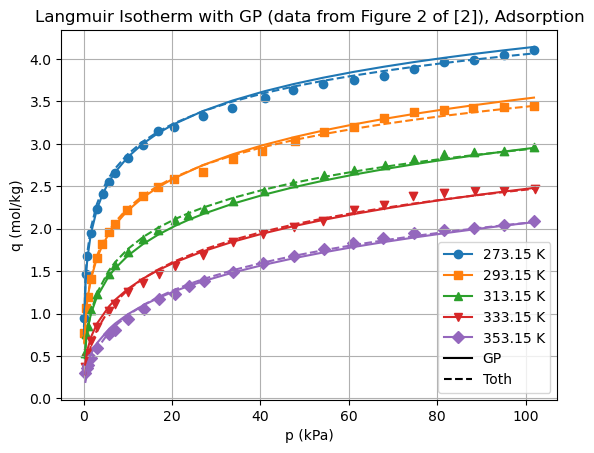

In [36]:
# Define styles and legend elements:

colors = mcolors.TABLEAU_COLORS  # dictionary of all colors
colors = list(colors.values())[:n]  # first 'n' colors, one per experiment

markers = ['o', 's', '^', 'v', 'D']
labels = list(f"{np.round(T[T_const[i]], 2)} K" for i in range(n))  # temperatures for legend

legend_elements = list(Line2D([0], [0], marker=markers[c], color=colors[c], label=labels[c]) for c in range(n)) + [Line2D([0], [0], ls='-', color='k', label='GP'), Line2D([0], [0], ls='--', color='k', label='Toth')]

# Plot:

fig, ax = plt.subplots()
for i in range(n):
    j = T_const[i]
    k = T_const[i + 1]

    plt.scatter(p_kPa[j:k], q[j:k], color=colors[i], marker=markers[i])  # experimental measurements
    plt.plot(p_kPa[j:k], qcal[j:k], '-', color=colors[i])  # GP model
    plt.plot(p_kPa[j:k], qcal_Toth[j:k], '--', color=colors[i])  # Toth model

ax.set_xlabel('p (kPa)')
ax.set_ylabel('q (mol/kg)')
ax.set_title('Langmuir Isotherm with GP (data from Figure 2 of [2]), Adsorption')
ax.legend(handles=legend_elements, loc='lower right')
ax.grid()

Training $\mathbf{GP}_{q_{max}}$ to obtain $q_{max}$ at any $T$, and validating:

[1, -17.69427966356508]
[2, -27.995758655659905]
[3, -28.794436856119415]
[4, -248.67592442470777]
[5, -248.67592442470777]
[6, -248.67592442470777]
[7, -248.67592442470777]


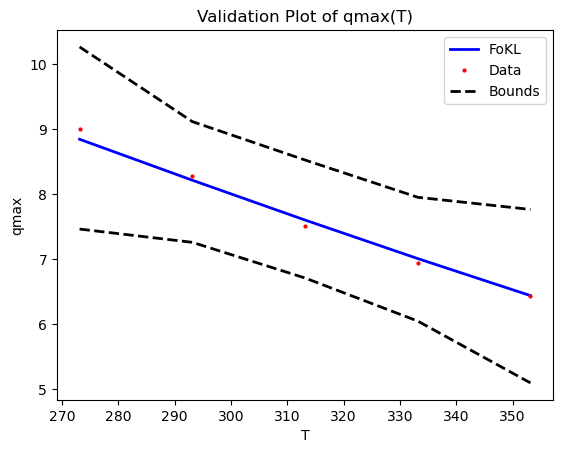

RMSE = 0.011743666945396747


In [37]:
# Training:
GP_qmax = FoKLRoutines.FoKL(kernel=1, UserWarnings=False, atau=1e-6)
_ = GP_qmax.fit(T[T_const[:-1]], qmax[T_const[:-1]], clean=True, minmax=[[T_min, T_max]])

# Validation:
_, _, rmse = GP_qmax.coverage3(plot=True, xaxis=0, xlabel='T', ylabel='qmax', title='Validation Plot of qmax(T)')
print(f"RMSE = {rmse}")

Reproducing $q/p$ plot but with $\theta_1$ instead of $q$, and using $\mathbf{GP}_{q_{max}}$ for calculation of the GP's $\theta_1$ value which greatly reduces accuracy but provides visual of what Pyomo will be working with:

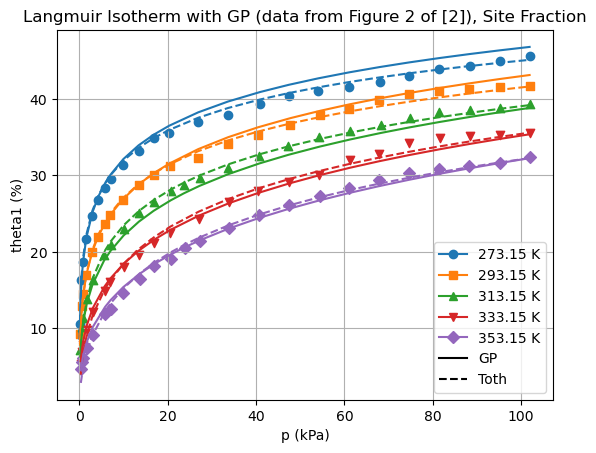

In [40]:
theta1_cal = np.zeros([sum(nd), 4])  # [measured, single GP, both GP's, Toth]

fig, ax = plt.subplots()
for i in range(n):
    j = T_const[i]
    k = T_const[i + 1]

    theta1_cal[j:k, 0] = q[j:k] / qmax[j:k] * 100  # measured
    theta1_cal[j:k, 1] = qcal_Toth[j:k] / qmax[j:k] * 100  # Toth
    theta1_cal[j:k, 2] = qcal[j:k] / qmax[j:k] * 100  # single GP (for later percent error comparison)
    theta1_cal[j:k, 3] = qcal[j:k] / GP_qmax.evaluate(T[j:k], clean=True) * 100  # both GP's
    
    plt.scatter(p_kPa[j:k], theta1_cal[j:k, 0], color=colors[i], marker=markers[i])  # experimental measurements
    plt.plot(p_kPa[j:k], theta1_cal[j:k, 1], '--', color=colors[i])  # Toth model
    plt.plot(p_kPa[j:k], theta1_cal[j:k, 3], '-', color=colors[i])  # GPs (uses GP_qmax for qmax, as Pyomo will use)

ax.set_xlabel('p (kPa)')
ax.set_ylabel('theta1 (%)')
ax.set_title("Langmuir Isotherm with GP (data from Figure 2 of [2]), Site Fraction")
ax.legend(handles=legend_elements, loc='lower right')
ax.grid()

Comparing prediction from GP's to Toth:

In [44]:
# Calculate percent errors:

qcal_perc_error = np.zeros([sum(nd), 2])  # [Toth, GP]
theta1_cal_perc_error = np.zeros([sum(nd), 3])  # [Toth, GP, GPs]

def perc_error(measured, predicted):
    """Return percent error."""
    return (predicted - measured) / measured * 100

qcal_perc_error[:, 0] = perc_error(q, qcal_Toth)  # should align with what is reported in [2]
qcal_perc_error[:, 1] = perc_error(q, qcal)  # single GP (Delta)

for i in range(3):
    theta1_cal_perc_error[:, i] = perc_error(theta1_cal[:, 0], theta1_cal[:, i + 1])

# Compare/Print percent errors:
_dec = 4  # decimals to round to
table_q = [['', 'Toth', 'GP'], 
           ['Average Value (%)'] + np.round(np.mean(qcal_perc_error, axis=0), _dec).tolist(), 
           ['Average Magnitude (%)'] + np.round(np.mean(np.abs(qcal_perc_error), axis=0), _dec).tolist(), 
           ['Standard Deviation (%)'] + np.round(np.std(qcal_perc_error, axis=0), _dec).tolist()]
print("Table 1. Percent error of amount adsorbed predictions.")
print(tabulate(table_q, headers='firstrow', tablefmt='fancy_grid'))
table_theta1 = [['', 'Toth', 'GP', 'GPs'], 
                ['Average Value (%)'] + np.round(np.mean(theta1_cal_perc_error, axis=0), _dec).tolist(), 
                ['Average Magnitude (%)'] + np.round(np.mean(np.abs(theta1_cal_perc_error), axis=0), _dec).tolist(), 
                ['Standard Deviation (%)'] + np.round(np.std(theta1_cal_perc_error, axis=0), _dec).tolist()]
print("Table 2. Percent error of site fraction predictions.")
print(tabulate(table_theta1, headers='firstrow', tablefmt='fancy_grid'))

print(f"\nIncrease in Average Magnitude: (GPs - Toth) / Toth = {np.round((table_theta1[2][3] - table_theta1[2][1]) / table_theta1[2][1] * 100, _dec)} %")

Table 1. Percent error of amount adsorbed predictions.
╒════════════════════════╤═════════╤════════╕
│                        │    Toth │     GP │
╞════════════════════════╪═════════╪════════╡
│ Average Value (%)      │ -1.1192 │ 0.2875 │
├────────────────────────┼─────────┼────────┤
│ Average Magnitude (%)  │  3.0557 │ 2.7025 │
├────────────────────────┼─────────┼────────┤
│ Standard Deviation (%) │  6.1127 │ 4.0387 │
╘════════════════════════╧═════════╧════════╛
Table 2. Percent error of site fraction predictions.
╒════════════════════════╤═════════╤════════╤════════╕
│                        │    Toth │     GP │    GPs │
╞════════════════════════╪═════════╪════════╪════════╡
│ Average Value (%)      │ -1.1192 │ 0.2875 │ 0.3627 │
├────────────────────────┼─────────┼────────┼────────┤
│ Average Magnitude (%)  │  3.0557 │ 2.7025 │ 3.1849 │
├────────────────────────┼─────────┼────────┼────────┤
│ Standard Deviation (%) │  6.1127 │ 4.0387 │ 4.2069 │
╘════════════════════════╧═════════╧══

### Conclusion

In Table 2, "GPs" refers to the use of $\mathbf{GP}_{q_{max}}$ in scaling $q_{cal}$ to $\theta_{1, cal}$. Recall both "Toth" and "GP" use $q_{max} = q_s$.

In regard to evaluating at any $(T, p)$ pair, the advantage of "GPs" is that the site fraction may be predicted; whereas, "GP" may only predict the amount adsorbed. "Toth", without the inclusion of $\mathbf{GP}_{q_{max}}$ or some other $q_{max}$ model, has the same issue as "GP". For this reason, "GPs" is advantageous for the simple reason that it models $q_{max}$.

The main concern in this benchmark comparison, then, is whether "GP" provides an improvement to "Toth". The percent errors are certainly lower and the average is much closer to $0$. Since "GPs" does not have a $1:1$ analogue and performs worse than "GP", as expected, the concern here is again in comparison to "Toth"; also, whether the decrease in performance compared to "GP" is significant so as to warrant a different method of modeling $q_{max}$ and ultimately the site fraction.

To the first concern regarding "GPs", Table 2 shows overall better performance than "Toth". The average magnitude, that is, the mean of the absolute values of the percent error, is often greater than in "Toth"; but, not by a significant amount. Due to the stochastic nature of GP models, it is possible for this value to be lower as well depending on the training of $\mathbf{GP}$ or $\mathbf{GP}_{q_{max}}$. See "Average Magnitude: (GPs - Toth) / Toth = ______" in the above output for the percent increase.

To the second concern, the performace of "GPs" is very close to that of "GP". There is room for improvement, but a different model of $q_{max}$ is unlikely to provide this improvement except by a little. Nonetheless, decreasing the RMSE of $\mathbf{GP}_{q_{max}}$ will drive the performance of "GPs" closer to "GP". For significant improvement overall, "GP" itself would need to perform better; or, a different appraoch entirely instead of modeling the exponent of the relative life may be needed. Nonetheless, "GPs" outperforms "Toth" overall and so proved successful in this benchmark comparison.

---

## Application to Nonlinear Programming

Converting $\mathbf{GP}_{q_{max}}$ to Pyomo for any nonlinear programming (NLP) optimization problem requiring $q(T, p)$:

In [49]:
m = fokl_to_pyomo([GP, GP_qmax], [['inv_T', 'ln_p'], ['T']], ['Delta', 'qmax'])

Developing Pyomo model:

In [50]:
# Create variables:
m.p = pyo.Var(within=pyo.NonNegativeReals)
m.sigma1 = pyo.Var(within=pyo.NonNegativeReals)
m.mu = pyo.Var(within=pyo.NonNegativeReals)
m.q = pyo.Var(within=pyo.NonNegativeReals)
m.theta1 = pyo.Var(within=pyo.NonNegativeReals, bounds=[0, 1])

# Define expressions:

m.constr_vars = pyo.ConstraintList()
m.constr_vars.add(expr=m.inv_T == 1/m.T)
m.constr_vars.add(expr=m.ln_p == log(m.p))

m.constr_eqs = pyo.ConstraintList()
m.constr_eqs.add(expr=m.mu == m.p/sqrt(2*np.pi*M*R*m.T))
m.constr_eqs.add(expr=m.sigma1 == exp(m.Delta))
m.constr_eqs.add(expr=m.q == m.sigma1*m.qmax*m.mu/(1 + m.sigma1*m.mu))
m.constr_eqs.add(expr=m.theta1 == m.q*m.qmax)

m.constr_eqs.pprint()

constr_eqs : Size=4, Index={1, 2, 3, 4}, Active=True
    Key : Lower : Body                               : Upper : Active
      1 :   0.0 :  mu - p/sqrt(2.2991139042557864*T) :   0.0 :   True
      2 :   0.0 :                sigma1 - exp(Delta) :   0.0 :   True
      3 :   0.0 : q - sigma1*qmax*mu/(1 + sigma1*mu) :   0.0 :   True
      4 :   0.0 :                    theta1 - q*qmax :   0.0 :   True


### Example Toy Problem

Problem:
- Find optimal $(T, p)$ to maximize $\theta_1$ while minimizing USD cost.

Parameters:
- $T_{\text{USD}} = \$3.50\ /\text{K}$
- $p_{\text{USD}} = \$2.75 \cdot \exp(p)\ /\text{kPa}$

Solution:
- It is expected that $T$ is at minimum of bounds, since $\theta_1 \propto T^{-1}$.
- It is expected that $p \approx (10,\ 30)\ \text{kPa}$, since $\theta_1 \propto \frac{ap}{1+ap}$ which loosely has shape of log plot.

### Analytic Solution

#### WRONG:

$\text{USD} = T_{\text{USD}} + p_{\text{USD}}$

$\theta_1 / \text{USD} = \frac{ap}{(1+ap)(T_{\text{USD}} + p_{\text{USD}})} = \frac{a p}{(1+a p)(c_T + c_p \exp(p))}
= \frac{a p}{c_T + c_p \exp(p) + a c_T p + a c_p p \exp(p)}
= a \frac{p}{g(p)}$

To maximize,

$\frac{d}{dp}(\theta_1 / \text{USD})
= a \frac{g(p)-p \frac{d}{dp}(g(p))}{(g(p))^2}
= -a \left(\frac{(ac_pp^2+c_pp-c_p)\exp(p)-c_T}{(ap+1)^2(c_p\exp(p)+c_T)^2}\right)$

Then,

$(ac_pp^2+c_pp-c_p)\exp(p)-c_T = 0$

With $a$ calculated, $p$ may be solved for. To calculate $a$,

$a = \frac{\sigma_1}{\sqrt{2\pi MRT}}$

Then,

$(\frac{\sigma_1}{\sqrt{2\pi MRT_{min}}}c_pp^2+c_pp-c_p)\exp(p)-c_T = 0$

#### REDO WITH:

Parameters:
- $T_{\text{USD}} = \$3.50 \cdot T$
- $p_{\text{USD}} = \$2.75 \cdot \exp(p)$

...

Define costs and set up Pyomo objective:

In [193]:
m.cost = pyo.Var(within=pyo.NonNegativeReals)
m.constr_cost = pyo.ConstraintList()
m.constr_cost.add(expr=m.cost == 3.50*m.T + m.p*2.75)

m.obj = pyo.Objective(expr=m.theta1 / m.cost, sense=pyo.maximize)

Solve NLP:

In [194]:
local = True

# -----------

if local is True:  # for debugging
    solver = pyo.SolverFactory('ipopt')
    solver.solve(m, tee=True)
    
else:  # actual example
    solver = pyo.SolverFactory('multistart')
    solver.solve(m, solver='ipopt', suppress_unbounded_warning=True)

Ipopt 3.14.16: 
Exception of type: DYNAMIC_LIBRARY_FAILURE in file "Common/IpLibraryLoader.cpp" at line 86:
 Exception message: libhsl.so: cannot open shared object file: No such file or directory

EXIT: Library loading failure.
model.name="unknown";
    - termination condition: other
    - message from solver: <undefined>


Retrieve solution:

In [195]:
sol = {'T': m.T(), 'p': m.p(), 'theta1': m.theta1(), 'cost': m.cost()}

print(f"     T = {sol['T']} K")
print(f"     p = {sol['p']} kPa")
print(f"theta1 = {np.round(sol['theta1'] * 100, 2)} %")
print(f"  cost = ${np.round(sol['cost'], 2)}")

print(f"{np.round(sol['theta1'] * 100 / sol['cost'], 2)} %/USD")

     T = 300.0 K
     p = None kPa


TypeError: unsupported operand type(s) for *: 'NoneType' and 'int'

Note it is expected that $T$ is at minimum of bounds, since $theta_1 \propto T^{-1}$; however, since $q \propto 

## References

<c id=1> [1] <c/> [THE ADSORPTION OF GASES ON PLANE SURFACES OF GLASS, MICA AND PLATINUM. <br>
&emsp;&nbsp; Irving Langmuir <br>
&emsp;&nbsp; Journal of the American Chemical Society 1918 40 (9), 1361-1403 <br>
&emsp;&nbsp; DOI: 10.1021/ja02242a004](https://pubs.acs.org/doi/epdf/10.1021/ja02242a004) <br>

<c id=2> [2] <c/> [Adsorption Equilibria of CO2 on Zeolite 13X and Zeolite X/Activated Carbon Composite <br>
&emsp;&nbsp; Jong-Seok Lee, Jong-Hwa Kim, Jin-Tae Kim, Jeong-Kwon Suh, Jung-Min Lee, and Chang-Ha Lee <br>
&emsp;&nbsp; Journal of Chemical & Engineering Data 2002 47 (5), 1237-1242 <br>
&emsp;&nbsp; DOI: 10.1021/je020050e](https://pubs.acs.org/doi/10.1021/je020050e) <br>